In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn model validation and preprocessing imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from future_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, cross_val_score

# import models to try 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Classificator's names
clfs_name = ["LogisticRegression", "SVC", "KNeighbors", "DecisionTree",
                "RandomForest", "GradientBoosting" ]

# Data import
titanic = pd.read_csv('train.csv')

# Drop useless columns and NaN values in the Embarked column
titanic.drop(columns = ["Ticket","Name","Cabin"], inplace=True)
titanic = titanic[titanic["Embarked"].isna()==False]

In [3]:
# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Numerical features columns names
num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Categorical features names
cat_features = ['Sex', 'Embarked']

# Pipeline for numerical features 
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_features)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# Pipeline for "Sex" features 
sex_pipeline = Pipeline([
        ('selector', DataFrameSelector(["Sex"])),
        ('sex_encoder', OrdinalEncoder()), #OneHotEncoder(sparse=False)
    ])

# Pipeline for "Embarked" features 
emb_pipeline = Pipeline([
        ('selector', DataFrameSelector(["Embarked"])),
        ('emb_encoder', OrdinalEncoder()), #OneHotEncoder(sparse=False)
    ])

# Data preparation pipeline
data_preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("sex_pipeline", sex_pipeline),
        ("emb_pipeline", emb_pipeline),
    ], n_jobs=1)

In [4]:
# Prepared data and labels for the fitting
X = data_preparation_pipeline.fit_transform(titanic)
y = titanic["Survived"].values

# Split data in a train and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state=42)

In [7]:
# Initialization of the classificators I whish to try 
clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier()) 

mean_clfs  = []
std_clfs = []
validation_score = []

# Cicle on the classifier. For each classifier we look for cross validation accuracy score. 
# We save the accuracy on the validation set as well
for name, classifier in zip(clfs_name, clfs):
    scores = cross_val_score(classifier, X_train, y_train, cv = 7, scoring="accuracy")
    print('---------------------------------')
    print(name, ':')
    print('---------------------------------')
    
    mean_clfs.append(scores.mean())
    std_clfs.append(scores.std())
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    validation_score.append(accuracy_score(y_val,y_pred))
    
    print('Mean: ', scores.mean())
    print('Std: ', scores.std())
    print('Validation set result: ',validation_score[-1]) 

---------------------------------
LogisticRegression :
---------------------------------
Mean:  0.7889106137504507
Std:  0.0402111896962666
Validation set result:  0.7865168539325843
---------------------------------
SVC :
---------------------------------
Mean:  0.8143023546052083
Std:  0.024571673600331943
Validation set result:  0.8202247191011236
---------------------------------
KNeighbors :
---------------------------------
Mean:  0.8002404526166903
Std:  0.026977500641610565
Validation set result:  0.7808988764044944
---------------------------------
DecisionTree :
---------------------------------
Mean:  0.7947646781484872
Std:  0.047455188086328905
Validation set result:  0.7359550561797753
---------------------------------
RandomForest :
---------------------------------
Mean:  0.8157309260337797
Std:  0.03434110372572288
Validation set result:  0.7921348314606742
---------------------------------
GradientBoosting :
---------------------------------
Mean:  0.8270188867626258


In [ ]:
# Convert lists into arrays
mean_clfs_num = np.asarray(mean_clfs)
std_clfs_num = np.asarray(std_clfs)
validation_score_num = np.asarray(validation_score)

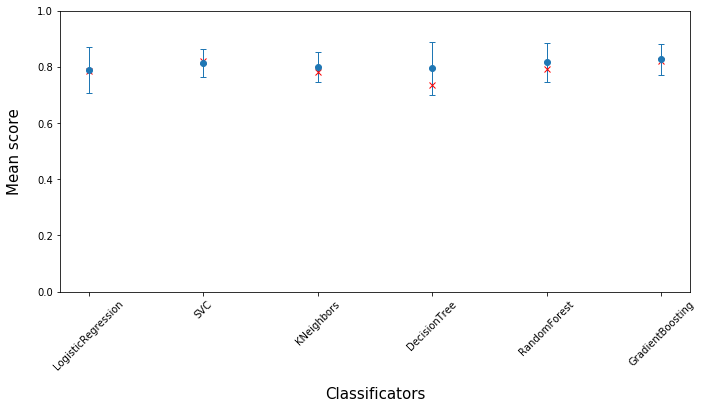

The classificator which performs better in average is:  GradientBoosting


In [16]:
# Visualization of the model scores
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('Results for each model')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.errorbar(np.arange(1,mean_clfs_num.size+1),mean_clfs_num,yerr=2*std_clfs_num,fmt='o',
            elinewidth=1, capsize=3, capthick=1)

plt.plot(np.arange(1,mean_clfs_num.size+1),validation_score_num,'rx')
plt.ylim((0,1))
plt.xticks(np.arange(1,mean_clfs_num.size+1), clfs_name, rotation=45)
ax1.set_xlabel('Classificators', labelpad=15, fontsize=15)
ax1.set_ylabel('Mean score', labelpad=15, fontsize=15)

plt.show()

print("The classificator which performs better in average is: ", clfs_name[mean_clfs_num.argmax()])

In [19]:
# Let us try to increment the performance of the GradientBoostingClassifier by tuning its hyperparameters

clf = GradientBoostingClassifier()

param_grid = [
    {'loss' : ['deviance', 'exponential'], 'n_estimators': list(range(90,110)),'max_depth': list(range(2,15))},
]

grid_search = GridSearchCV(clf, param_grid, cv=7, scoring='accuracy')

grid_search.fit(X_train, y_train)

Results: 
{'loss': 'exponential', 'max_depth': 5, 'n_estimators': 91}
Accuracy score on the train set:  0.9535864978902954
Accuracy score on the validation set:  0.8146067415730337


In [20]:
print("Results: ")
print(grid_search.best_params_)

clf_best = grid_search.best_estimator_
clf_best.fit(X_train, y_train)

y_train_pred = clf_best.predict(X_train)
accuracy_on_train = accuracy_score(y_train, y_train_pred)

y_val_pred = clf_best.predict(X_val)
accuracy_on_val = accuracy_score(y_val, y_val_pred)

print('Accuracy score on the train set: ', accuracy_on_train)
print('Accuracy score on the validation set: ', accuracy_on_val)


Results: 
{'loss': 'exponential', 'max_depth': 5, 'n_estimators': 91}
Accuracy score on the train set:  0.9535864978902954
Accuracy score on the validation set:  0.8146067415730337


In [23]:
give_solution = True

if give_solution:

    titanic_test = pd.read_csv('test.csv')

    X_test = data_preparation_pipeline.transform(titanic_test)

    y_predicted = grid_search.best_estimator_.predict(X_test).reshape(-1,1)
    pass_id = titanic_test["PassengerId"].values.reshape(-1,1)

    out = np.c_[pass_id, y_predicted]
    output = pd.DataFrame(out, columns = ["PassengerId", "Survived"])

    output.to_csv(path_or_buf="./Solution.csv", index=False)
    print("Output scritto")

Output scritto
